# Task 1: Implement the Classifier

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import cuda, nn, optim, no_grad, argmax, save, load, clamp, utils
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms, models

In [2]:
batch_size = 100
num_epochs = 12
num_classes = 10
learning_rate = 0.001

In [3]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
FASHION_transform = transforms.Compose([
    transforms.ToTensor(), # Transform from [0,255] uint8 to [0,1] float
])
FASHION_trainval = datasets.FashionMNIST('.', download=True, train=True, transform=FASHION_transform)
FASHION_train = Subset(FASHION_trainval, range(50000))
FASHION_val = Subset(FASHION_trainval, range(50000,60000))
FASHION_test = datasets.FashionMNIST('.', download=True, train=False, transform=FASHION_transform)
print("Done!")

Loading datasets...
Done!


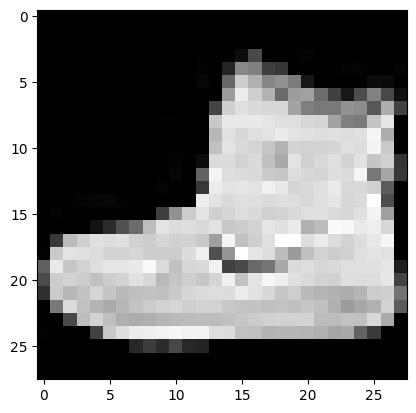

In [4]:
plt.imshow(FASHION_train[0][0][0], cmap='gray')

In [5]:
# Create dataloaders
trainloader = DataLoader(FASHION_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(FASHION_val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(FASHION_test, batch_size=batch_size, shuffle=True)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=500)
        self.drp_layer = nn.Dropout(0.2) # Fraction of units to drop to prevent of overfitting
        self.fc2 = nn.Linear(in_features=500, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self,x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drp_layer(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [7]:
device = "cuda" if cuda.is_available() else "cpu"

In [8]:
device

'cpu'

In [9]:
model = Network().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [12]:
def train(model, loader, num_epoch = num_epochs):
    print("Start training...")
    model.train()
    for i in range(num_epoch):
        running_loss = []
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, label)
            running_loss.append(loss.item())
            loss.backward() 
            optimizer.step()
        print("Epoch={}, Loss={}".format(i+1,np.mean(running_loss)))
    print("Finished.")

In [13]:
def evaluate(model, loader):
    model.eval() 
    correct = 0
    total = 0
    with no_grad():
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            total += label.size(0)
            correct += (argmax(pred,dim=1)==label).sum().item()
    print("\nEvaluation accuracy: {}".format(correct/total))
    return correct/total

In [14]:
train(model, trainloader, num_epochs)

Start training...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


Epoch=1, Loss=0.4524329125881195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.53it/s]


Epoch=2, Loss=0.3161489326059818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:50<00:00,  9.95it/s]


Epoch=3, Loss=0.2774735453426838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.23it/s]


Epoch=4, Loss=0.2564522220790386


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.14it/s]


Epoch=5, Loss=0.24145850931107998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.33it/s]


Epoch=6, Loss=0.2300000667721033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:22<00:00,  6.08it/s]


Epoch=7, Loss=0.2200870154052973


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:12<00:00,  6.90it/s]


Epoch=8, Loss=0.2066747596859932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:33<00:00,  5.36it/s]


Epoch=9, Loss=0.19770143015682698


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:11<00:00,  6.98it/s]


Epoch=10, Loss=0.19628068442642688


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:38<00:00,  3.15it/s]


Epoch=11, Loss=0.18353278452903032


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:47<00:00,  2.20it/s]

Epoch=12, Loss=0.17718655639886857
Finished.


In [15]:
print("Evaluation on Val Set... ")
evaluate(model, valloader)

Evaluation on Val Set... 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.92it/s]


Evaluation accuracy: 0.9116


0.9116

In [16]:
print("Evaluation on Test Set... ")
evaluate(model, testloader)

Evaluation on Test Set... 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.01it/s]


Evaluation accuracy: 0.9071


0.9071

In [17]:
path = F"classifier_fashion_mnist_8.pt" 
save(model, path)

# Task 2: Implement the Attack

### Helper functions

In [18]:
def show_adversarial_images(examples,labels):
    cnt = 0
    for j in range(len(examples)):
        cnt+=1
        plt.xticks([], [])
        plt.yticks([], [])
        orig,adv,ex = examples[j]
        plt.title(r'{} $\rightarrow$ {}'.format(labels[orig],labels[adv]))
        plt.imshow(ex, cmap="gray")
        plt.tight_layout()
        plt.show()

In [19]:
def show_step_wise_plot(iteration_wise_accuracy,steps) :
    y = iteration_wise_accuracy
    x = steps
    plt.title('PGD Attack Accuracy vs number of Steps')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')    
    plt.plot(x,y)
    plt.legend(['PGD attack accuracy', 'steps'])
    plt.show()

In [20]:
labels = { 0: 'T-shirt/top', 1: 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat' , 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker' , 8 : 'Bag' , 9 : 'Ankle boot'}

### FGSM Attack

In [21]:
model = load(path)
model.eval()

Network(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=2304, out_features=500, bias=True)
  (drp_layer): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=500, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
epsilon = 25/255 # perturbation magnitude
accurate_pred_output_before_attack = 0
wrong_pred_output_after_attack = 0
iteration_wise_accuracy = []

In [23]:
def fgsm_attack(image, epsilon, gdata):
    signed_gdata = gdata.sign()                            # Collect the element-wise sign of the data gradient
    adversarial_img = image + epsilon*signed_gdata         # Create the perturbed image by adjusting each pixel
    adversarial_img = clamp(adversarial_img, 0, 1)         # Adding clipping to maintain range between [0,1]
    return adversarial_img                                 # Return the perturbed image

In [24]:
def fgsm_test(model, device, test_loader, epsilon):
    ex = []                                                # 10 examples to visualize later
    correct_predictions_befatk = 0                         # Number of correct predictions before attack
    incorrect_predictions_aftatk = 0                       # Number of incorrect predictions after attack
    
    for data, target in tqdm(test_loader):                 # Loop over all examples in test set
        data, target = data.to(device), target.to(device)  # Send the data and label to the device
        data.requires_grad = True                          # Set requires_grad attribute of tensor. Important for Attack

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]         # Get the index of the max log-probability

        if init_pred.item() != target.item():              # If the initial prediction is wrong, dont attack
            continue
        correct_predictions_befatk += 1
        
        loss = F.nll_loss(output, target)                  # Calculate the loss
        model.zero_grad()                                  # Zero all existing gradients
        loss.backward()                                    # Calculate gradients of model in backward pass
        data_grad = data.grad.data                         # Collect datagrad

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad) 

        # Classify using the perturbed data
        output = model(perturbed_data)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1]        # get the index of the max log-probability
        if final_pred.item() != target.item():
            incorrect_predictions_aftatk += 1
            # Adversarial examples for visualization
            if len(ex) < 10:
                ex.append((init_pred.item(), final_pred.item(), perturbed_data.squeeze().detach().cpu().numpy()))
    
    # Calculate final accuracy for this epsilon
    result_accuracy = incorrect_predictions_aftatk / float(correct_predictions_befatk)
    print("FGSM Attack Success Rate = {}\n".format(result_accuracy))

    return result_accuracy, ex                                      # Return the accuracy and an adversarial example

In [25]:
# batch_size=1 loader
test_loader = utils.data.DataLoader(datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),])), batch_size=1, shuffle=True)

In [26]:
acc_FGSM, ex_FGSM = fgsm_test(model, device, test_loader, epsilon)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:05<00:00, 153.30it/s]

FGSM Attack Success Rate = 0.9250358284643369



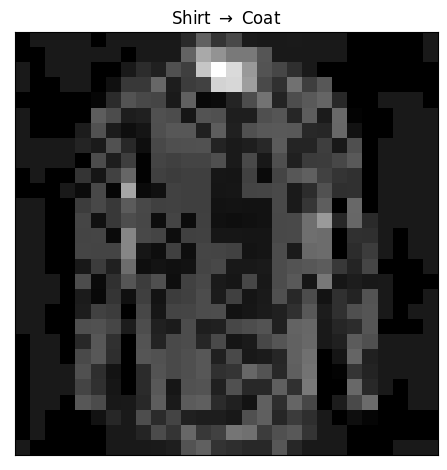

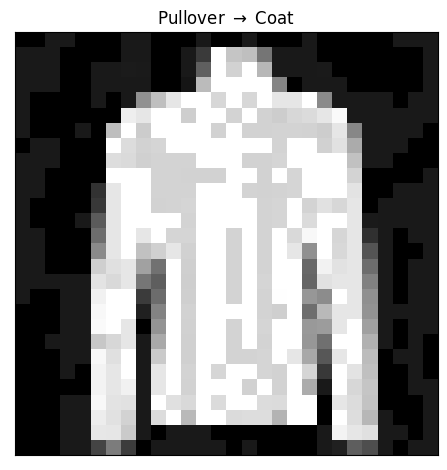

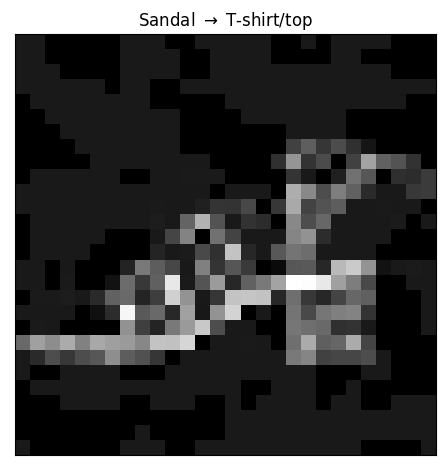

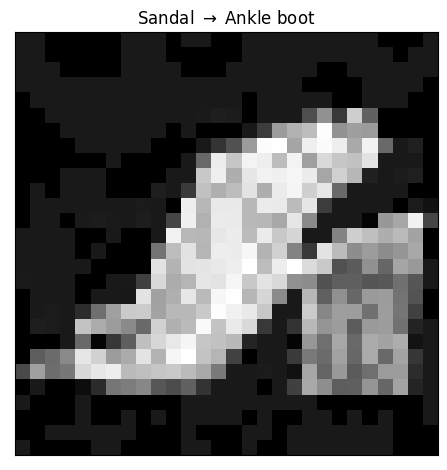

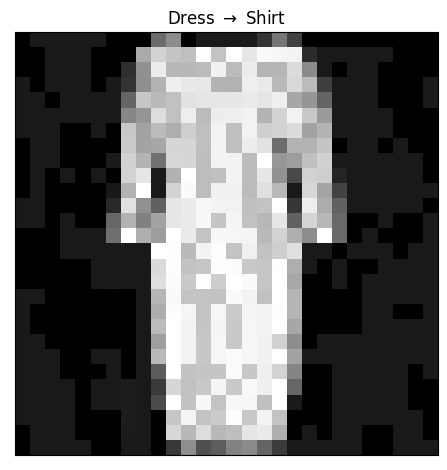

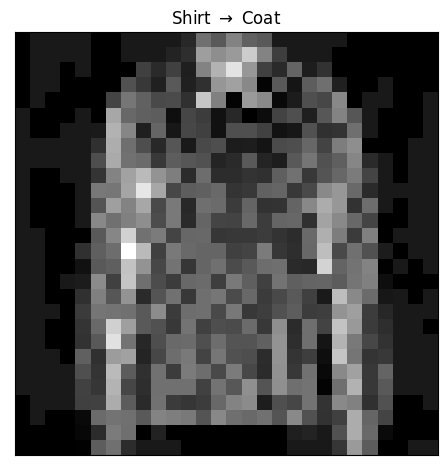

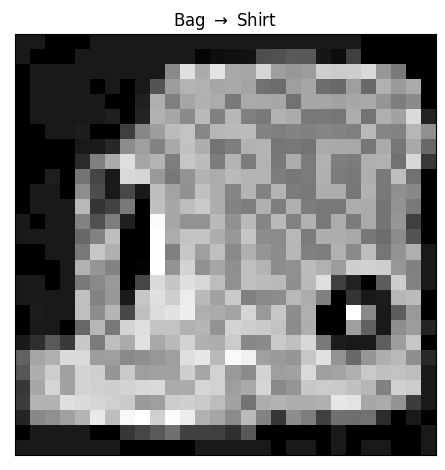

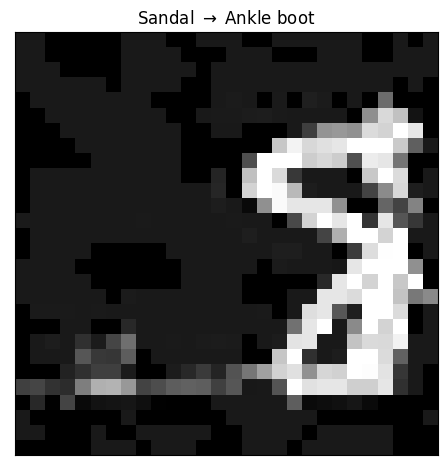

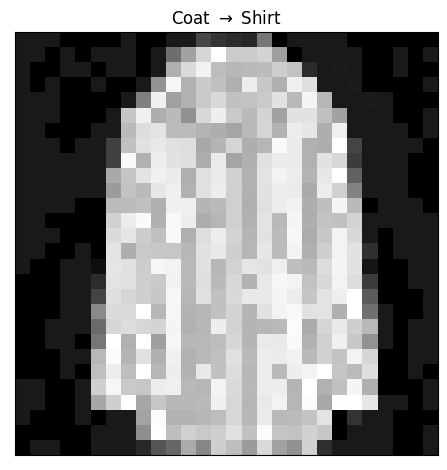

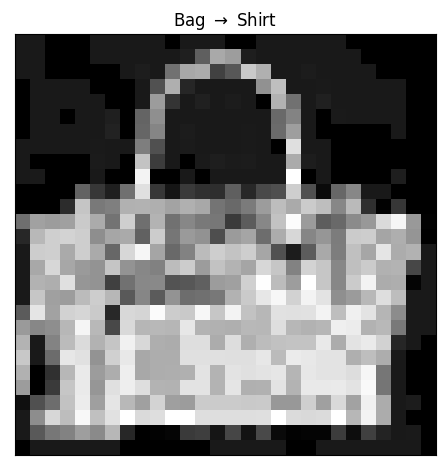

In [27]:
show_adversarial_images(ex_FGSM, labels)

### PGD Attack

In [28]:
def pgd_attack(model, image, label, epsilon, steps=10, alpha=2/255 ) :
    image_og = image            
    for i in range(steps) :    
        image.requires_grad = True
        loss = F.nll_loss(model(image), label)               # Calculating loss
        model.zero_grad()                                    # Zero all existing gradients 
        loss.backward()                                      # Calculate gradients of model in backward pass
        grad_data = image.grad.data	                         # Collect datagrad
        adversarial_img = image + alpha*grad_data.sign()
        eta = clamp(adversarial_img - image_og, min=-epsilon, max=epsilon)
        image = clamp(image_og + eta, min=0, max=1).detach_()
    return image

In [29]:
def test_PGD (model, device, test_loader, epsilon,steps=10) :
    ex = []                                               # Adversarial examples
    incorrect_predictions_aftatk = 0                      # Accuracy counter
    correct_predictions_befatk = 0
    

    for data,target in tqdm(test_loader) :
        data, target = data.to(device), target.to(device) # Send the data and label to the device
        data.requires_grad = True                         # Set requires_grad attribute of tensor. Important for Attack
        
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]        # log-probability max's index

        # If the initial prediction is wrong do not attack
        if init_pred.item() != target.item():
            continue
        correct_predictions_befatk += 1	

        perturbed_data = pgd_attack(model,data.to(device),target.to(device),epsilon,steps)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() != target.item():
            incorrect_predictions_aftatk += 1
            # Save some adv examples for visualization later
            if len(ex) < 10:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                ex.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    result_accuracy = incorrect_predictions_aftatk/float(correct_predictions_befatk)
    print("\nPGD Attack Success Rate = {}\n".format(result_accuracy))

    iteration_wise_accuracy.append(result_accuracy)
    return result_accuracy, ex                                   # Return the accuracy and an adversarial example

In [30]:
steps_array = [1,2,5,10]
print("PGD Attack")  
for steps in steps_array:
    acc_PGD, ex_PGD = test_PGD(model, device, test_loader, epsilon, steps)

PGD Attack


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 144.80it/s]



PGD Attack Success Rate = 0.08080696725829567



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:28<00:00, 67.25it/s]



PGD Attack Success Rate = 0.195017087421453



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:12<00:00, 39.62it/s]



PGD Attack Success Rate = 0.5226546136037923



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:24<00:00, 19.84it/s]


PGD Attack Success Rate = 0.9532576342189395



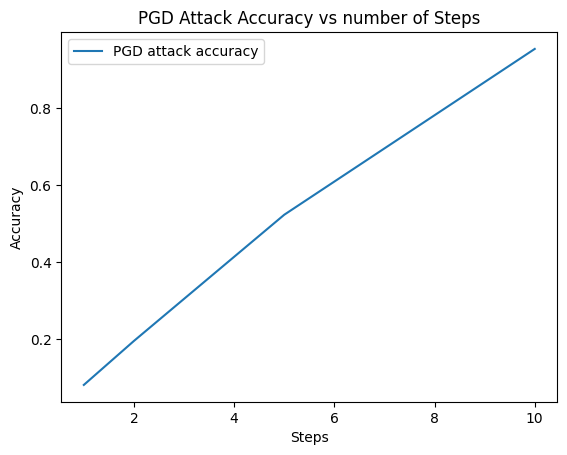

In [31]:
show_step_wise_plot(iteration_wise_accuracy,steps_array)

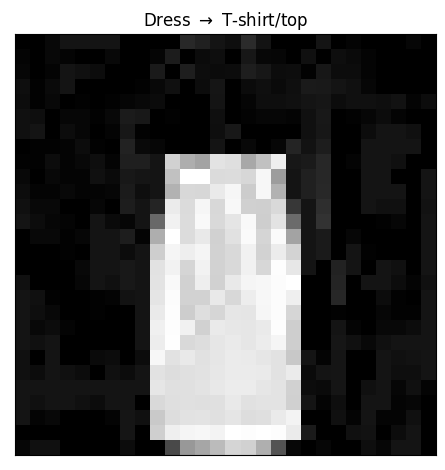

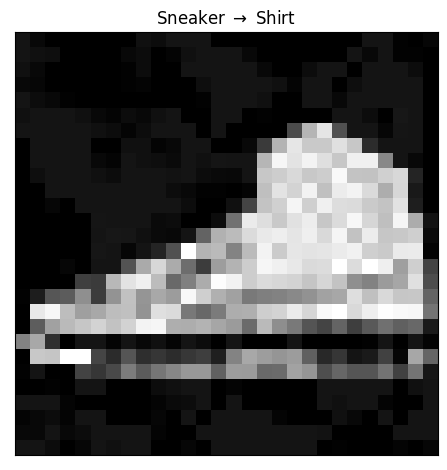

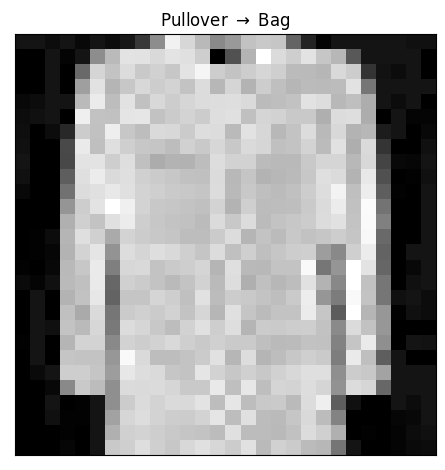

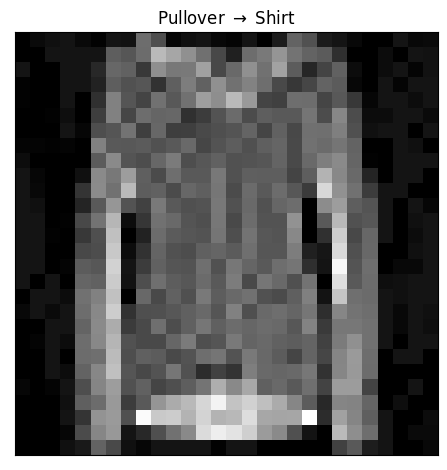

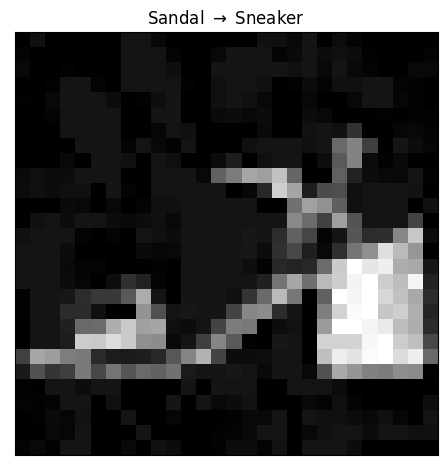

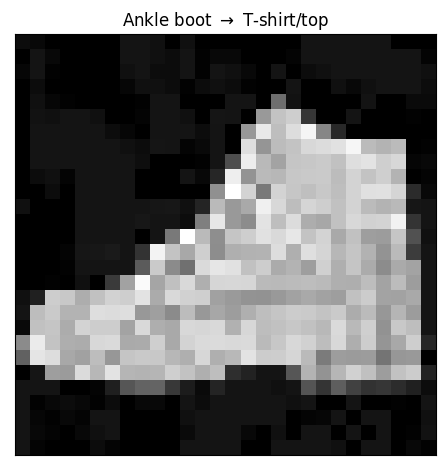

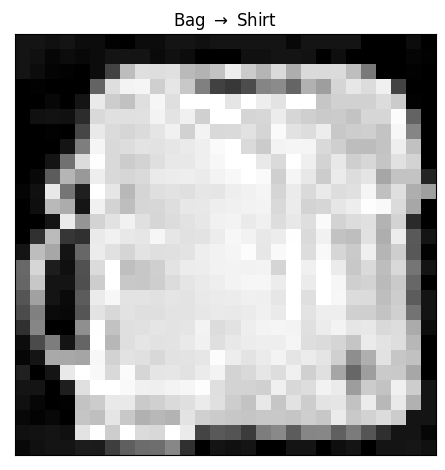

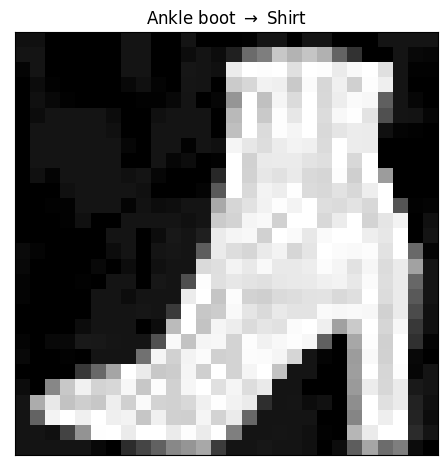

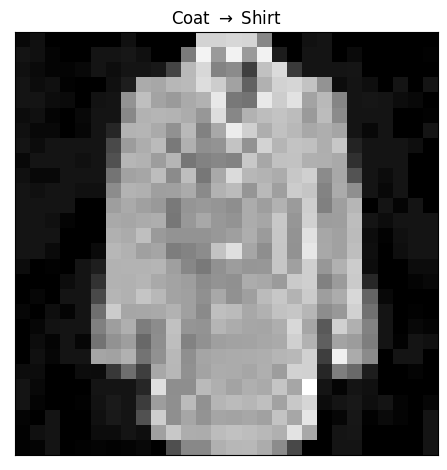

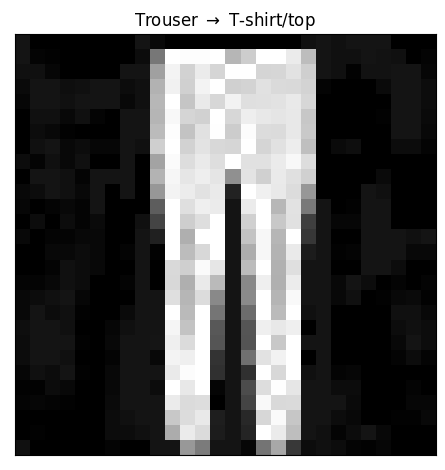

In [32]:
show_adversarial_images(ex_PGD,labels)